**Вардумян А.Т. ИУ5-61Б**

<a id='0'></a>
# Оглавление

2. [Задание](#1)<br>
3. [Описание датасета](#2)<br>
4. [Импорт библиотек](#3)<br>
5. [Загрузка и первичный анализ данных](#4)<br>
6. [Построение модели](#5)<br>
7. [Подбор гиперпараметра K](#6)<br>

<a id="1"></a>
# Задание ([к оглавлению](#0))

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

<a id="2"></a>
# Описание датасета ([к оглавлению](#0))

Digital payments are evolving, but so are cyber criminals.

According to the Data Breach Index, more than 5 million records are being stolen on a daily basis, a concerning statistic that shows - fraud is still very common both for Card-Present and Card-not Present type of payments.

In today’s digital world where trillions of Card transaction happens per day, detection of fraud is challenging.


This Dataset sourced by some unnamed institute.

---

**Feature Explanation:**

`distancefromhome` - the distance from home where the transaction happened.

`distancefromlast_transaction` - the distance from last transaction happened.

`ratiotomedianpurchaseprice` - Ratio of purchased price transaction to median purchase price.

`repeat_retailer` - Is the transaction happened from same retailer.

`used_chip` - Is the transaction through chip (credit card).

`usedpinnumber` - Is the transaction happened by using PIN number.

`online_order` - Is the transaction an online order.

`fraud` - Is the transaction fraudulent.

<a id="3"></a>
# Импорт библиотек ([к оглавлению](#0))

In [2]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

<a id="4"></a>
# Загрузка и первичный анализ данных ([к оглавлению](#0))

In [3]:
df = pd.read_csv("card_transdata.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df = df.rename(columns={
    "distance_from_home": "dist_home",
    "distance_from_last_transaction": "dist_last",
    "ratio_to_median_purchase_price": "ratio",
    "repeat_retailer": "repeat",
    "used_chip": "chip",
    "used_pin_number": "pin",
    "online_order": "online"
})

In [5]:
df.describe()

,dist_home,dist_last,ratio,repeat,chip,pin,online,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.shape

(1000000, 8)

In [6]:
#возьмем только 50000 первых строк
df = df.head(50000)

In [7]:
discrete_features = [
    "repeat",
    "chip",
    "pin",
    "online",
    "fraud"
]

for feat in discrete_features:
    df[feat] = df[feat].astype(int)
    print(f'Колонка {feat}: {df[feat].unique()}')

Колонка repeat: [1 0]
Колонка chip: [1 0]
Колонка pin: [0 1]
Колонка online: [0 1]
Колонка fraud: [0 1]


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   dist_home  50000 non-null  float64
 1   dist_last  50000 non-null  float64
 2   ratio      50000 non-null  float64
 3   repeat     50000 non-null  int64  
 4   chip       50000 non-null  int64  
 5   pin        50000 non-null  int64  
 6   online     50000 non-null  int64  
 7   fraud      50000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 3.1 MB


In [9]:
df.corr()

,dist_home,dist_last,ratio,repeat,chip,pin,online,fraud
dist_home,1.000000,-0.004150,0.002670,0.136132,-0.001765,0.005620,-0.001649,0.180288
dist_last,-0.004150,1.000000,-0.001902,-0.010311,-0.006626,0.001329,-0.001758,0.103179
ratio,0.002670,-0.001902,1.000000,0.001572,0.008193,0.004216,-0.002310,0.458288
repeat,0.136132,-0.010311,0.001572,1.000000,0.002110,-0.000668,0.006170,-0.001257
chip,-0.001765,-0.006626,0.008193,0.002110,1.000000,-0.004120,0.001536,-0.062658
pin,0.005620,0.001329,0.004216,-0.000668,-0.004120,1.000000,0.000945,-0.100114
online,-0.001649,-0.001758,-0.002310,0.006170,0.001536,0.000945,1.000000,0.192275
fraud,0.180288,0.103179,0.458288,-0.001257,-0.062658,-0.100114,0.192275,1.000000


In [10]:
df.corr()['fraud']

dist_home    0.180288
dist_last    0.103179
ratio        0.458288
repeat      -0.001257
chip        -0.062658
pin         -0.100114
online       0.192275
fraud        1.000000
Name: fraud, dtype: float64

<AxesSubplot:>

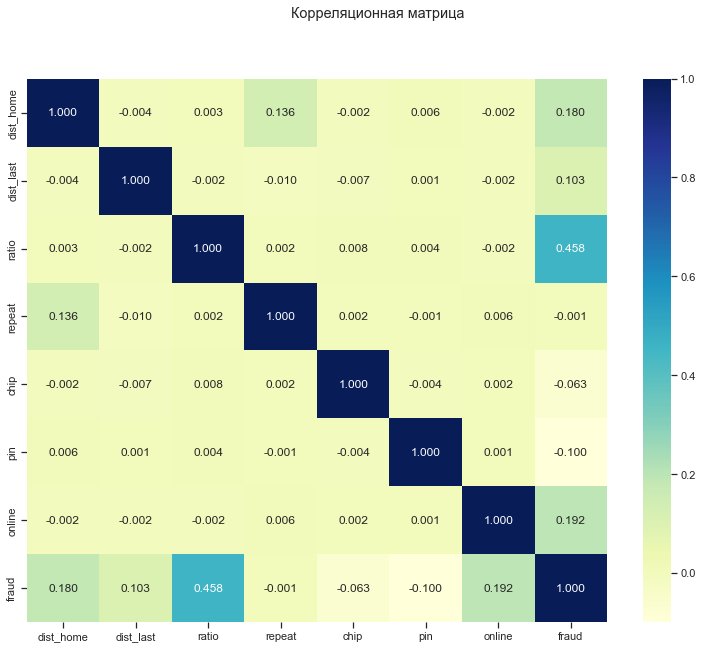

In [11]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(13,10))
fig.suptitle('Корреляционная матрица')
sns.heatmap(df.corr(), ax=ax, annot=True, fmt='.3f', cmap='YlGnBu')

<a id="5"></a>
# Построение модели ([к оглавлению](#0))

In [1]:
X_train, X_test, y_train, y_test = \
train_test_split(df.loc[:, df.columns != 'fraud'], df["fraud"], test_size=0.2, random_state=1)

NameError: name 'df' is not defined

In [13]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    labels, counts = np.unique(array, return_counts=True)
    counts_perc = counts/array.size
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {:<10} \t {}%'.format(i, val, val_perc_100))

In [14]:
print_class_proportions(y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 36538      	 91.34%
1 	 3462       	 8.65%


In [15]:
print_class_proportions(y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 9145       	 91.45%
1 	 855        	 8.55%


In [16]:
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train, y_train)
target10 = knn10.predict(X_test)
len(target10), target10

(10000, array([0, 0, 0, ..., 0, 0, 0]))

In [17]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    classes = np.unique(y_true)
    res = dict()

    for c in classes:
        temp_data_flt = df[df['t']==c]
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        res[c] = temp_acc
        
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [18]:
print_accuracy_score_for_classes(y_test, target10)

Метка 	 Accuracy
0 	 0.9825041006014216
1 	 0.6608187134502924


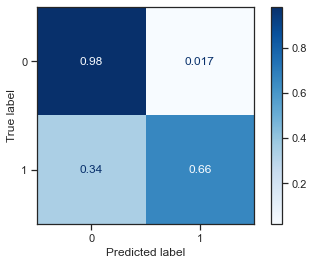

In [19]:
plot_confusion_matrix(knn10, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

In [20]:
print(classification_report(y_test, target10))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      9145
           1       0.78      0.66      0.72       855

    accuracy                           0.95     10000
   macro avg       0.87      0.82      0.85     10000
weighted avg       0.95      0.95      0.95     10000



In [21]:
recall_score(y_test, target10)

0.6608187134502924

In [22]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

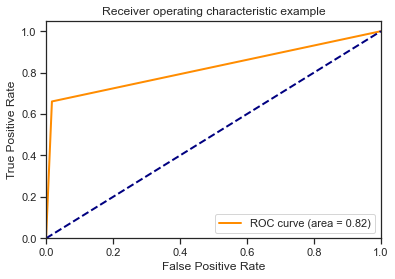

In [23]:
# Для 10 ближайших соседей
draw_roc_curve(y_test, target10, pos_label=1, average='micro')

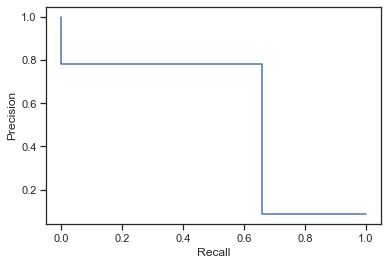

In [24]:
precision, recall, _ = precision_recall_curve(y_test, target10)
display = PrecisionRecallDisplay(precision, recall)
display.plot()

<a id="6"></a>
# Подбор гиперпараметра K ([к оглавлению](#0))

## K_Fold cross-validation

In [25]:
X = df.loc[:, df.columns != 'fraud']
y = df["fraud"]

In [26]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(),
                      param_grid={'n_neighbors': range(1,10,1)},
                      cv=KFold(n_splits=5),
                      scoring='recall',
                      n_jobs=-1
)
clf_gs.fit(X, y)

CPU times: user 158 ms, sys: 76.3 ms, total: 234 ms
Wall time: 12 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, scoring='recall')

In [27]:
clf_gs.best_score_

0.803486310666689

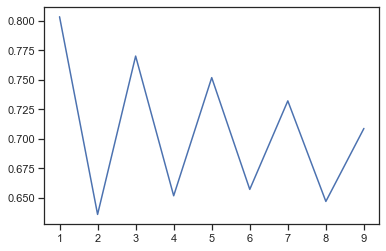

In [28]:
plt.plot(range(1,10,1), clf_gs.cv_results_['mean_test_score'])

In [38]:
target_gs = clf_gs.best_estimator_.predict(X)

In [39]:
print(classification_report(y, target_gs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9145
           1       1.00      1.00      1.00       855

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



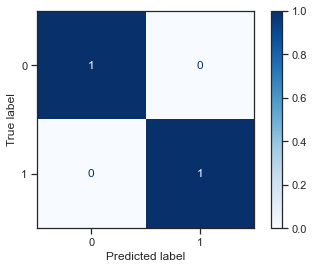

In [31]:
plot_confusion_matrix(clf_gs.best_estimator_, X, y, cmap=plt.cm.Blues, normalize='true')

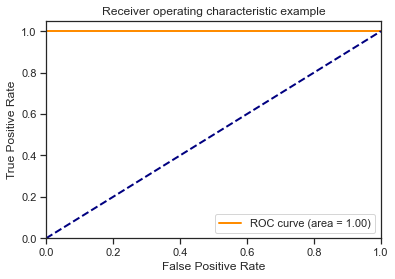

In [32]:
draw_roc_curve(y, target_gs, pos_label=1, average='micro')

## StratifiedKFold cross-validation

In [33]:
%%time
clf_gs_stf = GridSearchCV(KNeighborsClassifier(),
                          param_grid={'n_neighbors': range(1,10,1)},
                          cv=StratifiedKFold(n_splits=5),
                          scoring='recall',
                          n_jobs=-1
)
clf_gs_stf.fit(X, y)

CPU times: user 218 ms, sys: 29.6 ms, total: 248 ms
Wall time: 8.19 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, scoring='recall')

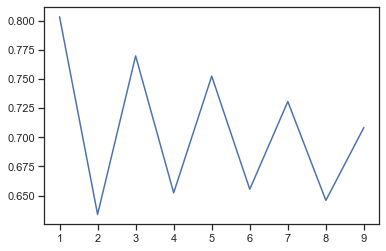

In [34]:
plt.plot(range(1,10,1), clf_gs_stf.cv_results_['mean_test_score'])

In [35]:
clf_gs_stf.best_score_

0.8033399854083516

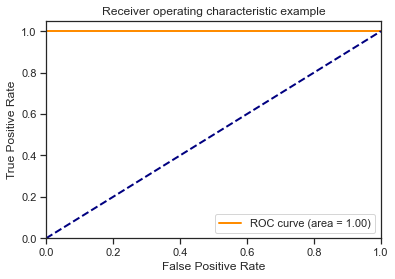

In [36]:
target_gs_stf = clf_gs_stf.best_estimator_.predict(X)
draw_roc_curve(y, target_gs_stf, pos_label=1, average='micro')

## Сравнение моделей

|Метрика|Начальная модель K=10|Оптимальная модель (KFold)|Оптимальная модель (StratifiedKFold)|
| :- | :-: | :-: | :-: |
|Recall|0.66|0.8|0.8|
|AUC|0.82|1|1|